In [1]:
using JLD2
using Plots
using Statistics
using Printf
using LinearAlgebra

gr()


sigma_list = [0.0, 0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]

9-element Vector{Float64}:
 0.0
 0.001
 0.002
 0.005
 0.01
 0.05
 0.1
 0.2
 0.5

In [2]:
"""
Loads the JLD2 data files generated by noisy_get_data.jl.
Returns a dictionary mapping sigma values to their results.
"""
function load_all_data(sigma_list)
    all_data = Dict{Float64, Dict}()
    
    for σ in sigma_list
        filename = joinpath(@__DIR__ , "noise$(σ).jld2")
        
        if isfile(filename)
            try
                file = jldopen(filename, "r")
                if haskey(file, "entanglement_spectrum_results")
                    results = read(file, "entanglement_spectrum_results")
                    all_data[σ] = results
                    println("Loaded: $filename")
                else
                     println("Warning: Key 'entanglement_spectrum_results' not found in $filename")
                end
                close(file)
            catch e
                println("Error loading $filename: $e")
            end
        else
            println("Missing: $filename")
        end
    end
    
    return all_data
end

data_library = load_all_data(sigma_list)



Loaded: c:\Users\Ethan\OneDrive - University of Bristol\Labs\Y4 Labs\A_Ethan_code\A_Noise_analysis\noise0.0.jld2
Missing: c:\Users\Ethan\OneDrive - University of Bristol\Labs\Y4 Labs\A_Ethan_code\A_Noise_analysis\noise0.001.jld2
Missing: c:\Users\Ethan\OneDrive - University of Bristol\Labs\Y4 Labs\A_Ethan_code\A_Noise_analysis\noise0.002.jld2
Missing: c:\Users\Ethan\OneDrive - University of Bristol\Labs\Y4 Labs\A_Ethan_code\A_Noise_analysis\noise0.005.jld2
Missing: c:\Users\Ethan\OneDrive - University of Bristol\Labs\Y4 Labs\A_Ethan_code\A_Noise_analysis\noise0.01.jld2
Missing: c:\Users\Ethan\OneDrive - University of Bristol\Labs\Y4 Labs\A_Ethan_code\A_Noise_analysis\noise0.05.jld2
Missing: c:\Users\Ethan\OneDrive - University of Bristol\Labs\Y4 Labs\A_Ethan_code\A_Noise_analysis\noise0.1.jld2
Missing: c:\Users\Ethan\OneDrive - University of Bristol\Labs\Y4 Labs\A_Ethan_code\A_Noise_analysis\noise0.2.jld2
Missing: c:\Users\Ethan\OneDrive - University of Bristol\Labs\Y4 Labs\A_Ethan_cod

Dict{Float64, Dict} with 1 entry:
  0.0 => Dict(78=>[0.417778, 0.417778, 0.37799, 0.37799, 0.309264, 0.309264, 0.…

In [3]:
"""
DETERMINES THE TRUNCATION CUTOFF
--------------------------------
Analyzes where the noisy spectrum deviates from the clean physics.
Returns the 'Safe Cutoff' value to use in DMRG to avoid fitting noise.
"""
function determine_noise_cutoff(results_clean, results_noisy; tolerance=0.2, safety_factor=2.0)
    noise_floors = Float64[]
    
    common_Ns = intersect(keys(results_clean), keys(results_noisy))
    
    for N in common_Ns
        clean = sort(results_clean[N], rev=true)
        noisy = sort(results_noisy[N], rev=true)
        
        # Compare only up to the length of the clean physics
        min_dim = min(length(clean), length(noisy))
        
        divergence_val = 0.0
        found = false
        
        for i in 1:min_dim
            val_c = clean[i]
            val_d = noisy[i]
            
            # If clean is effectively zero (<1e-15) but noisy is not, this is the floor
            if val_c < 1e-15 && val_d > 1e-15
                divergence_val = val_d
                found = true
                break
            end
            
            # Check relative deviation
            denom = max(val_c, 1e-16)
            if abs(val_c - val_d) / denom > tolerance
                divergence_val = val_d
                found = true
                break
            end
        end
        
        # If no obvious divergence in the head, the tail IS the noise
        if !found 
            if length(noisy) > min_dim
                divergence_val = noisy[min_dim+1]
            else
                 divergence_val = noisy[end]
            end
        end
        
        push!(noise_floors, divergence_val)
    end
    
    # We take the maximum noise floor found across all N as the conservative system-wide cutoff
    max_noise_floor = isempty(noise_floors) ? 0.0 : maximum(noise_floors)
    recommended_cutoff = max_noise_floor * safety_factor
    
    return recommended_cutoff, max_noise_floor
end



cutoffs = Dict{Float64, Float64}()
println("\n--- Calculating Cutoffs ---")
for σ in sort(collect(keys(data_library)))
    if σ == 0.0 continue end
    rec_cutoff, floor_val = determine_noise_cutoff(results_clean, data_library[σ])
    cutoffs[σ] = rec_cutoff
    println("σ=$σ -> Recommended Cutoff: $(@sprintf("%.2e", rec_cutoff))")
end


--- Calculating Cutoffs ---


In [4]:
"""
Calculates how much 'weight' (probability) is lost if we apply the recommended cutoff.
"""
function calculate_discarded_weight(noisy_data, cutoff)
    println("  N  | Original Chi | New Chi | Discarded Weight (Err)")
    println("  ---|--------------|---------|-----------------------")
    
    sorted_Ns = sort(collect(keys(noisy_data)))
    
    for N in sorted_Ns
        coeffs = sort(noisy_data[N], rev=true)
        
        # Indices to keep
        keep_mask = coeffs .> cutoff
        
        chi_orig = length(coeffs)
        chi_new = count(keep_mask)
        
        # Sum of squares of discarded values
        discarded_vals = coeffs[.!keep_mask]
        trunc_err = sum(discarded_vals .^ 2)
        
        if N % 10 == 0 # Print every 10th N to save space
            @printf "  %-3d| %-12d | %-7d | %.2e\n" N chi_orig chi_new trunc_err
        end
    end
end


println("\n--- Verifying Truncation Safety ---")
for σ in sort(collect(keys(data_library)))
    if σ == 0.0 continue end
    println("\nVerification for σ=$σ (Cutoff: $(@sprintf("%.2e", cutoffs[σ])))")
    calculate_discarded_weight(data_library[σ], cutoffs[σ])
end 


--- Verifying Truncation Safety ---


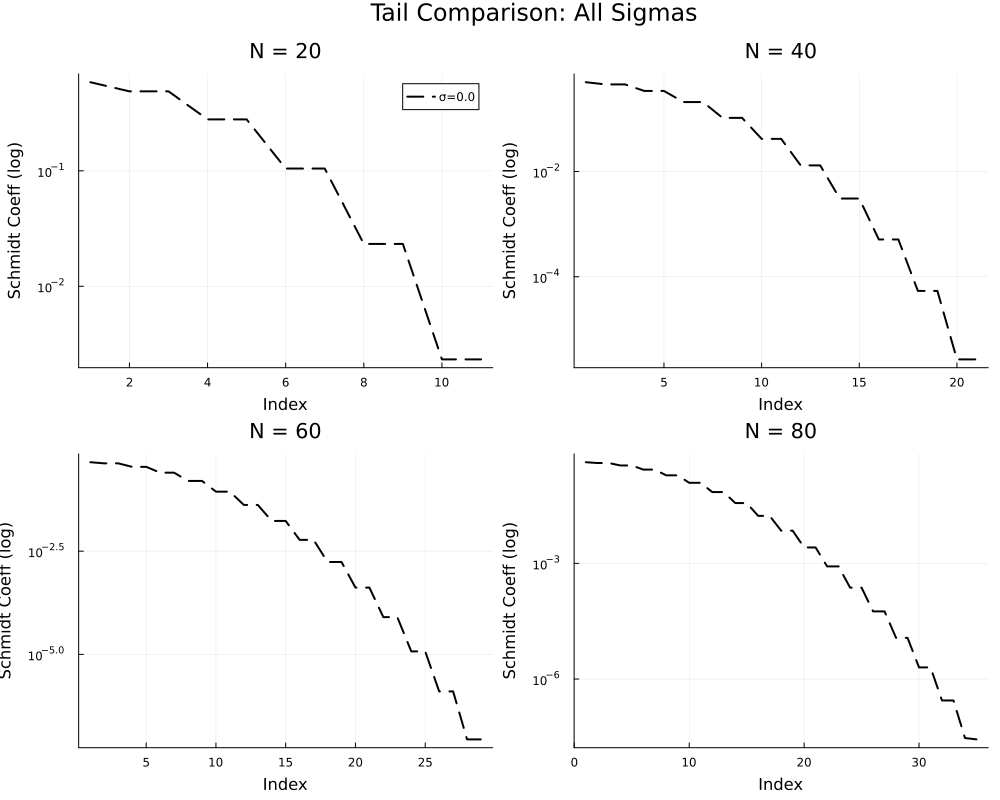

In [5]:
"""
Plots the Schmidt coefficient tails for a subset of N values.
Overlays ALL available sigmas on the same plot for comparison.
"""
function plot_tail_comparison_all(data_library; 
                                  N_subset=[20, 40, 60, 80],
                                  xlim_val=nothing)
    
    sorted_sigmas = sort(collect(keys(data_library)))
    plots = []

    for N in N_subset
        p = plot(title="N = $N", 
                 xlabel="Index", 
                 ylabel="Schmidt Coeff (log)", 
                 yaxis=:log10,
                 legend=(N == N_subset[1] ? :topright : false))
        
        for σ in sorted_sigmas
            if !haskey(data_library[σ], N) continue end
            
            v = sort(data_library[σ][N], rev=true)
            mask = v .> 1e-20 # Filter pure zeros
            y = v[mask]
            x = (1:length(v))[mask]
            
            if σ == 0.0
                plot!(p, x, y, label="σ=0.0", color=:black, lw=2, linestyle=:dash)
            else
                plot!(p, x, y, label="σ=$σ", lw=1.5, alpha=0.7)
            end
        end
        
        if xlim_val !== nothing
            plot!(p, xlims=(0, xlim_val))
        end
        push!(plots, p)
    end
    
    if isempty(plots)
        return plot(title="No data")
    end

    layout_dims = (Int(ceil(length(plots)/2)), 2)
    plot(plots..., layout=layout_dims, size=(1000, 800), plot_title="Tail Comparison: All Sigmas")
end

p_tails = plot_tail_comparison_all(data_library, N_subset=[20, 40, 60, 80])
display(p_tails)

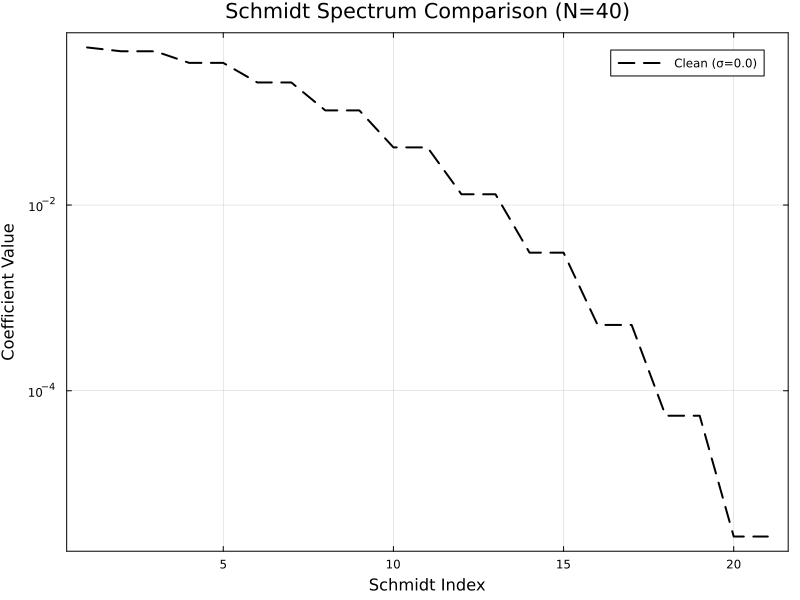

In [6]:
"""
Plots spectra for a single system size N, comparing Clean vs chosen Sigmas.
"""
function plot_single_N_comparison(data_library, N::Int, sigmas_to_plot::Vector{Float64})
    
    if !haskey(data_library[0.0], N)
        println("Data for N=$N not found in clean set.")
        return plot()
    end

    p = plot(title="Schmidt Spectrum Comparison (N=$N)",
             xlabel="Schmidt Index",
             ylabel="Coefficient Value",
             yaxis=:log10,
             framestyle=:box,
             grid=true,
             legend=:topright,
             size=(800, 600))
    
    # 1. Plot chosen noisy sigmas
    for σ in sigmas_to_plot
        if !haskey(data_library, σ) || !haskey(data_library[σ], N)
            println("Warning: Data for σ=$σ, N=$N missing.")
            continue
        end
        
        v = sort(data_library[σ][N], rev=true)
        mask = v .> 1e-20
        plot!(p, v[mask], label="σ=$σ", lw=2, alpha=0.8)
    end
    
    # 2. Plot Clean Baseline
    v_clean = sort(data_library[0.0][N], rev=true)
    mask_c = v_clean .> 1e-20
    plot!(p, v_clean[mask_c], label="Clean (σ=0.0)", color=:black, linestyle=:dash, lw=2)

    return p
end


p_single = plot_single_N_comparison(data_library, 40, [0.002, 0.01])
display(p_single)

In [7]:
"""
Calculates the index where the clean and disordered spectra deviate.
Returns a Dict mapping N -> Deviation Index.
"""
function calculate_deviation_indices(results_clean, results_disordered; threshold=0.1)
    deviation_indices = Dict{Int, Int}()
    common_Ns = intersect(keys(results_clean), keys(results_disordered))
    
    for N in sort(collect(common_Ns))
        v_clean = sort(results_clean[N], rev=true)
        v_disorder = sort(results_disordered[N], rev=true)
        
        min_len = min(length(v_clean), length(v_disorder))
        dev_idx = min_len 
        
        for i in 1:min_len
            val_c = v_clean[i]
            val_d = v_disorder[i]
            
            if val_c < 1e-16 || val_d < 1e-16
                if abs(val_c - val_d) > 1e-10
                    dev_idx = i
                    break
                end
                continue
            end
            
            rel_diff = abs(val_c - val_d) / max(val_c, val_d)
            if rel_diff > threshold
                dev_idx = i
                break
            end
        end
        deviation_indices[N] = dev_idx
    end
    return deviation_indices
end




calculate_deviation_indices


--- Deviation Index Analysis ---


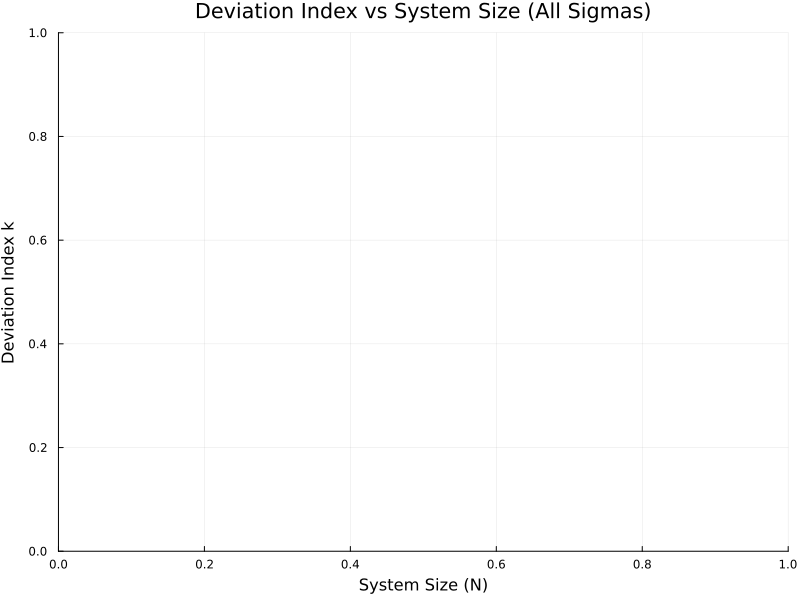

In [8]:

"""
Plots deviation indices.
- Shows individual plots for each sigma
- Shows one combined plot with all sigmas
"""
function plot_deviation_indices(data_library; threshold=0.1)
    clean = data_library[0.0]
    sorted_sigmas = sort([s for s in keys(data_library) if s != 0.0])
    
    # Combined Plot
    p_combined = plot(title="Deviation Index vs System Size (All Sigmas)",
                      xlabel="System Size (N)", ylabel="Deviation Index k",
                      legend=:topleft, grid=true, size=(800, 600))
    
    for σ in sorted_sigmas
        indices_dict = calculate_deviation_indices(clean, data_library[σ], threshold=threshold)
        Ns = sort(collect(keys(indices_dict)))
        vals = [indices_dict[N] for N in Ns]
        
        # Add to combined plot
        plot!(p_combined, Ns, vals, label="σ=$σ", marker=:circle, lw=2)
        
        # Individual Plot
        p_indiv = plot(Ns, vals, 
                       title="Deviation Index (σ=$σ)",
                       xlabel="N", ylabel="Index k",
                       legend=false, marker=:circle, color=:blue)
        display(p_indiv)
    end
    
    display(p_combined)
end

println("\n--- Deviation Index Analysis ---")
plot_deviation_indices(data_library, threshold=0.2)

In [9]:
"""
Calculates tail weights for ALL sigmas based on their respective deviation indices.
"""
function calculate_all_tail_weights(data_library; threshold=0.1)
    clean = data_library[0.0]
    all_weights = Dict{Float64, Dict{Int, Float64}}()
    
    for σ in keys(data_library)
        if σ == 0.0 continue end
        
        dev_indices = calculate_deviation_indices(clean, data_library[σ], threshold=threshold)
        weights_for_sigma = Dict{Int, Float64}()
        
        for (N, idx) in dev_indices
            coeffs = sort(data_library[σ][N], rev=true)
            
            # Tail Weight: Sum(λ_i^2) for i >= idx
            w_tail = (idx <= length(coeffs)) ? sum(coeffs[idx:end] .^ 2) : 0.0
            weights_for_sigma[N] = w_tail
        end
        
        all_weights[σ] = weights_for_sigma
    end
    return all_weights
end


all_tail_weights = calculate_all_tail_weights(data_library)
println("Tail weights calculated for sigmas: ", keys(all_tail_weights))

Tail weights calculated for sigmas: Float64[]


In [10]:
"""
Plots the analysis results (Deviation Index & Weights) for a SINGLE chosen sigma.
"""
function plot_analysis_results(data_library, chosen_sigma; threshold=0.1)
    
    if !haskey(data_library, chosen_sigma)
        println("Sigma $chosen_sigma not found.")
        return
    end
    
    clean = data_library[0.0]
    noisy = data_library[chosen_sigma]
    
    dev_indices = calculate_deviation_indices(clean, noisy, threshold=threshold)
    
    Ns = sort(collect(keys(dev_indices)))
    indices = [dev_indices[N] for N in Ns]
    
    tails = Float64[]
    diffs = Float64[]
    
    for N in Ns
        idx = dev_indices[N]
        coeffs = sort(noisy[N], rev=true)
        w_tail = (idx <= length(coeffs)) ? sum(coeffs[idx:end].^2) : 0.0
        w_head = (idx > 1) ? sum(coeffs[1:idx-1].^2) : 0.0
        
        push!(tails, w_tail)
        push!(diffs, w_head - w_tail)
    end
    
    p1 = plot(Ns, indices, title="Deviation Index (σ=$chosen_sigma)",
              ylabel="Index k", marker=:diamond, legend=false, color=:blue)
    p2 = plot(Ns, tails, title="Tail Weight (Σλ² > k)",
              ylabel="Weight", marker=:circle, legend=false, color=:red)
    p3 = plot(Ns, diffs, title="Head - Tail Weight",
              xlabel="System Size N", ylabel="Diff", marker=:rect, legend=false, color=:green)
    
    l = @layout [a{0.5h}; b c]
    p_final = plot(p1, p2, p3, layout=l, size=(1000, 800), margin=5Plots.mm)
    
    display(p_final)
end


plot_analysis_results(data_library, 0.002, threshold=0.2)

Sigma 0.002 not found.
